# Categorisez automatiquement des questions - Exploration

In [1]:
%%script echo skipping
from google.colab import drive
drive.mount('/content/drive')

skipping


# SOMMAIRE
* [PREPARATION](#PREPARATION)
* [CHARGEMENT](#CHARGEMENT)
* [Monogram](#Monogram)
    * [BAG OF WORDS](#BAG-OF-WORDS)
    * [TF-IDF](#TF-IDF)
        * [Bodies](#Bodies)
        * [Titles](#Titles)
        * [Pondere](#Pondere)
        * [Bodies+titles](#Bodies+titles)
    * [REDUCTION DIMENSIONNELLE - ACP](#REDUCTION-DIMENSIONNELLE---ACP)
    * [CLUSTERING](#CLUSTERING)
* [Bi-grams](#Bi-grams)
* [Tri-grams](#Tri-grams)
*[Tags](#Tags)
    * [Classement-TF-IDF](#Tags)
    * [Labellisation](#Labellisation)

# PREPARATION

## Import des librairies

In [2]:
import time

import joblib
import pandas as pd
import matplotlib as mplt
import matplotlib.pyplot as plt
from matplotlib import cm #colormap
import numpy as np

import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn import cluster, metrics
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn import naive_bayes
from sklearn.metrics import r2_score, accuracy_score

from sklearn.manifold import TSNE

from collections import Counter

## Paramétrage du notebook

In [3]:
from matplotlib import font_manager

font_dirs = ['/Library/Fonts/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# set font
plt.rcParams['font.family'] = 'Comic Sans'
plt.rcParams['font.sans-serif'] = 'Franklin Gothic Book'

In [4]:
sns.set(rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'dimgrey',
 'xtick.bottom': False,
 'xtick.color': 'dimgrey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'dimgrey',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})

#mplt.font_manager._rebuild()
#mplt.font_manager.findfont('Franklin Gothic Book',rebuild_if_missing=True)


pd.options.display.max_colwidth=200
pd.options.display.min_rows=25
pd.options.display.max_columns=50

## Declaration des fonctions

In [5]:
def count_words(list):
    # create counter and run through all data
    counter = Counter()
    freq = Counter(list) 
    return freq

def bow(documents):
    cv=CountVectorizer()
    cv.fit(documents)
    vector=cv.transform(documents)
    dfBOW=pd.DataFrame(data=vector.toarray(),columns=cv.get_feature_names_out())
    return dfBOW
def confusionMatrixAcc(y_true, y_pred):
    """
    Fonction qui retourne la matrice de confusion

    Parameters
    ----------
    y_true : pandas Series
        une Serie de valeurs (labels) reelles
    y_pred : pandas Series
        une Serie de valeurs (labels) predites
    Returns
    -------
    confusionMatrix : DataFrame
        la matrice de confusion
    """

    dfConfusion=pd.crosstab(y_test, y_pred_test,rownames=['Reel'], colnames=['Predit'], margins=False)
    confusionMatrix=pd.DataFrame()

    for c in dfConfusion.columns:
        TP=dfConfusion.loc[c,c]
        FP=dfConfusion.loc[:,c].sum()-dfConfusion.loc[c,c]
        TN=np.diagonal(dfConfusion).sum()-dfConfusion.loc[c,c]
        FN=dfConfusion.loc[c,:].sum()-dfConfusion.loc[c,c]
        TPR=TP/(TP+FN) # taux de vrai positif
        FPR=FP/(FP+TN) # taux de faux positifs
        Accuracy=(TP+TN)/(TP+FP+TN+FN)
        confusionMatrix=pd.concat([confusionMatrix,
        pd.DataFrame({
            'Class':c,
            'TP':[TP],
            'FP':[FP],
            'TN':[TN],
            'FN':[FN],
            'TPR':[TPR],
            'FPR':[FPR],
            'Accuracy':[Accuracy]})
            ])
    
    confusionMatrix.reset_index(drop=True,inplace=True)
    confusionMatrix=confusionMatrix.sort_values('Accuracy',ascending=False)
    return confusionMatrix

def getClass(row):
    # no de colonne ayant le TFIDF max
    if row.max()==0: # TF IDF nul pour toute la ligne
        return -1
    else:
        tags=row.idxmax().split() #separation du bigramme
        print(tags)
        rowclass=tagclass.get(tags[0],-1)
        if rowclass<0:
            print('row negative')
            rowclass=tagclass.get(tags[1],-1)
        return rowclass

# CHARGEMENT

In [6]:
# Calculate the time elapsed in seconds
start = time.time()

In [7]:
#dfCleaned=joblib.load("drive/MyDrive/Colab Notebooks/Datasets/dfCleaned.jbl.bz2")
dfCleaned=joblib.load('dfCleaned2000.jbl.bz2')

In [8]:
dfCleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 43576 to 48725
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        2000 non-null   object
 1   Body         2000 non-null   object
 2   Tags         2000 non-null   object
 3   BodyLemmas   2000 non-null   object
 4   TitleLemmas  2000 non-null   object
dtypes: object(5)
memory usage: 93.8+ KB


In [9]:
dfCleaned.sample(8)

,Title,Body,Tags,BodyLemmas,TitleLemmas
8077,excute an application which works with versions.,"<p>good day,</p>\n\n<p>currently i'm working on a simple code where i want to start a new application by using the fallowing code: </p>\n\n<pre><code> processinfo.filename = @""t:\app.ex...",c# winforms process publishing asp.net-4.5,"[good, currently, work, simple, code, want, start, new, appli, use, fallowing, code, processinfo, filename, app, exe, processinfo, redirectstan, true, processinfo, redirectstan, true, processinfo,...","[excute, application, work, version]"
40133,updatin xml in php,<p>hi every one i have an xml file and want to update my code is following</p>\n\n<pre><code>&lt;gallerylist&gt;\n &lt;record&gt;\n &lt;movie&gt;videos/15avatar_hd.flv&lt;/movie&gt;\n &lt;t...,php xml,"[hi, every, one, xml, file, want, code, follow, gallerylist, record, title, avatar, title, desc, play, kind, video, file, flash, player, support, desc, preview, video, preview, jpg, preview, imgpl...","[updatin, xml, php]"
42856,java how to update an instance in a method?,"<p>ok, i am confused. i try to update a value of an instance in a method in an interface.</p>\n<pre><code>public interface icalculationmethods {\n\n static void matchmonitor(game game) {\n ...",java spring-boot jpa,"[ok, confuse, try, value, instance, method, interf, public, interf, static, void, matchmonitor, game, game, player, player, game, getplayer, player, player, game, getplayer, int, scoreplayer, int,...","[java, update, instance, method]"
9124,cordova in ios blank white screen,"<p>i am using cordova in ios. all my html pages are loading fine.but, sometimes i am getting white blank screen instead of the content.how to resolve it?</p>\n",cordova,"[use, cordova, io, html, page, lo, fine, sometimes, get, white, blank, screen, inste, content, resolve]","[cordova, io, blank, white, screen]"
44081,how to get result?,<p>hello! sorry for my question. i hope you'll ask and help me. </p>\n\n<p>i want to get result with this code: </p>\n\n<pre><code>nsnumber *first = @10;\nnsnumber *second = @30;\nnsnumber *result...,objective-c,"[hello, sorry, question, hope, ask, help, want, get, result, code, nsnumber, first, nsnumber, second, nsnumber, resulttest, first, second, xcode, get, error, unfortunately, vari, class, nsnumber, ...","[get, result]"
26840,how to make app's language equal to phone's language,"<p>i have two files in my app, <code>english.strings</code> and <code>arabic.strings</code> where all app strings are put with their keys. there is an option in the app which allows user to choose...",ios swift localization translation,"[two, file, app, english, string, ar, string, app, string, put, key, option, app, allows, user, choose, whether, want, ar, english, language, work, fine, want, support, app, follow, phone, languag...","[make, app, language, equal, phone, language]"
45717,"quickest, and least maintenance way to build a website?","<p>i'm a database guy, and i'm trying build an application and for it i need build a website as front end. i need to take input from pages after uses logs in, store it in the database, and retriev...",web-frameworks,"[guy, try, build, appli, need, build, website, front, end, need, take, input, page, us, log, store, retrieve, later, user, search, mine, display, think, site, since, guy, never, venture, ui, side,...","[quick, least, maintenance, way, build, website]"
25816,how to find a bug in gtk+,"<p>what is the best way to hack away a bug in gtk+? the bug in <a href=""https://bugzilla.gnome.org/show_bug.cgi?id=127840"" rel=""nofollow noreferrer"">https://bugzilla.gnome.org/show_bug.cgi?id=1278...",debugging gtk,"[best, way, away, bug, gtk, bug, rel, nofollow, irritate, would, like, see, work, version, many, line, code, find, correct, part, code, use]","[find, bug, gtk]"


In [10]:
bodies=dfCleaned['BodyLemmas'].map(' '.join)
titles=dfCleaned['TitleLemmas'].map(' '.join)

# Pour tenir compte des titres, on les concatene aux corps de message
dfCleaned['BodyTitleLemmas']=dfCleaned['BodyLemmas']+dfCleaned['TitleLemmas']
bodies_titles=dfCleaned['BodyTitleLemmas'].map(' '.join)

In [11]:
# N premiers résultats à garder
N=30

# BAG OF WORDS

In [12]:
dfBowBodies=bow(bodies)
nBowBodies=dfBowBodies.to_numpy() # optimisation des calculs en passant par numpy

dfBowTitles=bow(titles)
nBowTitles=dfBowTitles.to_numpy() # optimisation des calculs en passant par numpy

In [13]:
%%time
dfSumBowBodies=pd.DataFrame(data=nBowBodies.sum(axis=0))
dfSumBowBodies.index=dfBowBodies.columns
dfSumBowBodies.columns=['count']

dfSumBowTitles=pd.DataFrame(data=nBowTitles.sum(axis=0))
dfSumBowTitles.index=dfBowTitles.columns
dfSumBowTitles.columns=['count']

dfSumBowTitlesHead=dfSumBowTitles.sort_values(by='count',ascending=False).head(N)
dfSumBowBodiesHead=dfSumBowBodies.sort_values(by='count',ascending=False).head(N)

CPU times: user 65.7 ms, sys: 31 ms, total: 96.7 ms
Wall time: 96.4 ms


In [14]:
from IPython.display import display_html 


df1_styler = dfSumBowTitlesHead.style.set_table_attributes("style='display:inline'").set_caption('dfSumBowTitlesHead')
df2_styler = dfSumBowBodiesHead.style.set_table_attributes("style='display:inline'").set_caption('dfSumBowBodiesHead')

space = "\xa0" * 10
display_html(df1_styler._repr_html_()+ space  + df2_styler._repr_html_(), raw=True)

,count
use,202
file,122
get,99
error,85
value,73
work,68
array,65
string,64
android,61
data,59


In [15]:
dfSumBowBodies['count']

ae                4
aea               4
aeaf              1
aearnedruns       2
aehrt             1
aenean            3
aes               1
af                4
afb               1
afefontmanage     1
affair            3
affect           10
                 ..
ёстой             1
شماره             2
محمد              2
مریذ              1
مریز              2
مریض              2
مریظ              1
کارت              2
کاظمی             2
การโทรกล          1
บร                1
歓迎                2
Name: count, Length: 14975, dtype: int64

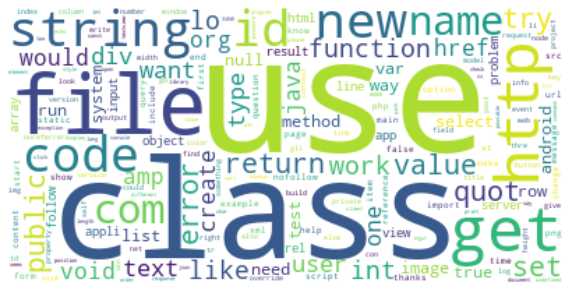

In [16]:
from wordcloud import WordCloud

plt.rcParams['figure.figsize'] = (10, 10)

wordcloud = WordCloud(max_words=1000000,background_color="white").generate_from_frequencies(dfSumBowBodies['count'])

plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

# Monogram

## TF-IDF

In [17]:
# Initialisation du vectoriseur TF IDF de scikit learn
vectorizer= TfidfVectorizer()

### Bodies

In [18]:
response= vectorizer.fit_transform(bodies)
dfTFIDF_bodies=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_bodies=dfTFIDF_bodies.sum(axis=0).sort_values(ascending=False)

[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TFIDF - bodies classement des mots')]

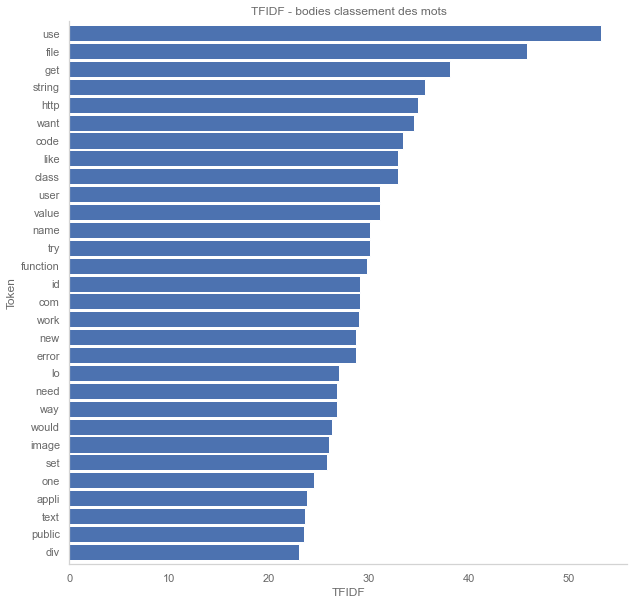

In [19]:
ax = sortedTFIDF_bodies.head(N).plot(kind='barh', width=0.90)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TFIDF - bodies classement des mots')

### Titles

In [20]:
%%time
response= vectorizer.fit_transform(titles)
dfTFIDF_titles=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_titles=dfTFIDF_titles.sum(axis=0).sort_values(ascending=False)

CPU times: user 54.1 ms, sys: 18.6 ms, total: 72.8 ms
Wall time: 76.2 ms


[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TFIDF - titles - classement des mots')]

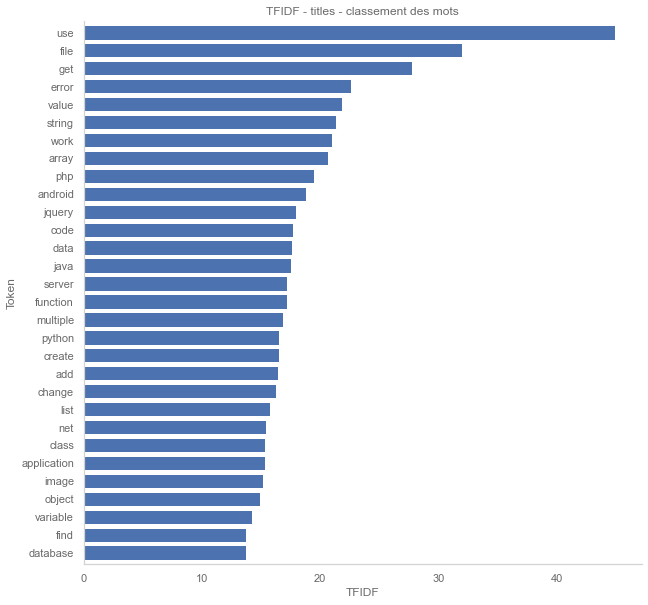

In [21]:
ax = sortedTFIDF_titles.head(N).plot(kind='barh', width=0.80)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TFIDF - titles - classement des mots')

In [22]:
dfTFIDF_titles.shape,dfTFIDF_bodies.shape

((2000, 3044), (2000, 14975))

### Pondere

TF-IDF (Pondéré) = TF-IDF(title) * alpha + TF-IDF(body) * (1-alpha)  
par ex. avec alpha=0.8

In [23]:
commonTokens=list(set(dfTFIDF_titles.columns) & set(dfTFIDF_bodies.columns))
dfTFIDFCommon=dfTFIDF_titles[0:10000][commonTokens]*0.8+dfTFIDF_bodies[0:10000][commonTokens]*0.2
sortedTFIDFCommon=dfTFIDFCommon.sum(axis=0).sort_values(ascending=False)

In [24]:
dfTFIDFCommon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 2296 entries, graph to vim
dtypes: float64(2296)
memory usage: 35.0 MB


<AxesSubplot:>

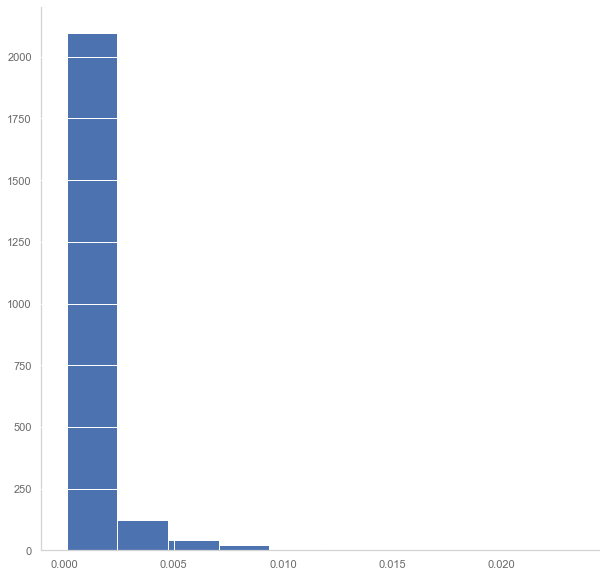

In [25]:
dfTFIDFCommon.mean(axis=0).hist()

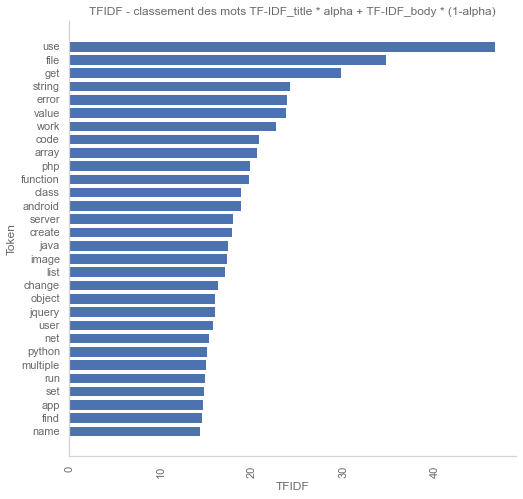

In [26]:
plt.figure(figsize=(8,8))

plt.barh(sortedTFIDFCommon.head(N).index,sortedTFIDFCommon.head(N).values)
plt.gca().invert_yaxis()

plt.xlabel("TFIDF")
plt.xticks(rotation='vertical')

plt.ylabel("Token")
plt.title("TFIDF - classement des mots TF-IDF_title * alpha + TF-IDF_body * (1-alpha)")
plt.show()

In [27]:
X=dfTFIDFCommon.values
X.shape

(2000, 2296)

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


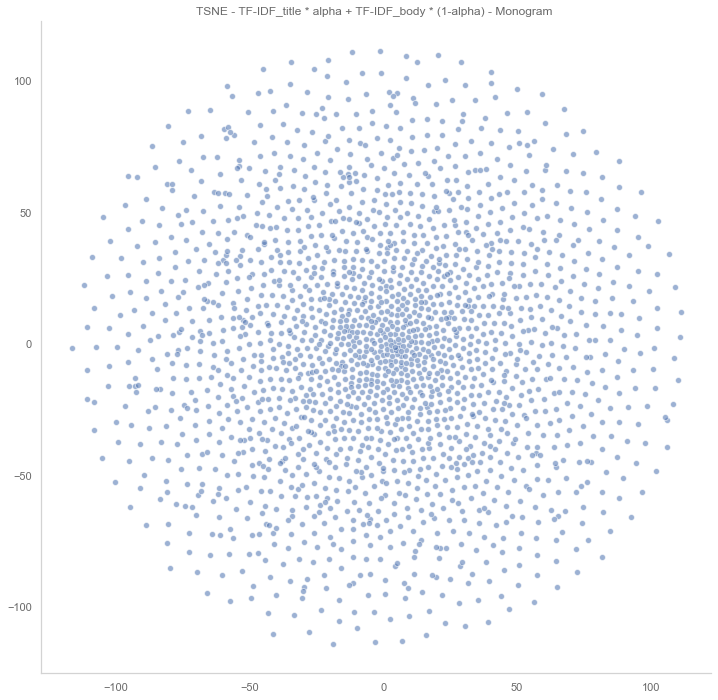

In [28]:
#%%time
tsne = TSNE(random_state=1, method='barnes_hut',n_iter=1000, n_components = 2)
tsne_results = tsne.fit_transform(X)

# graph TSNE
plt.figure(figsize = (12,12))


plt.scatter(tsne_results[:,0],tsne_results[:,1], edgecolor = "white", alpha=0.55)
plt.title('TSNE - TF-IDF_title * alpha + TF-IDF_body * (1-alpha) - Monogram ')
plt.show()

### Bodies+titles

In [29]:
%%time
response= vectorizer.fit_transform(bodies_titles)
dfTFIDF_bodies_titles=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_bodies_titles=dfTFIDF_bodies_titles.sum(axis=0).sort_values(ascending=False)

CPU times: user 379 ms, sys: 80.2 ms, total: 459 ms
Wall time: 409 ms


[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TFIDF - bodies_titles - classement des mots')]

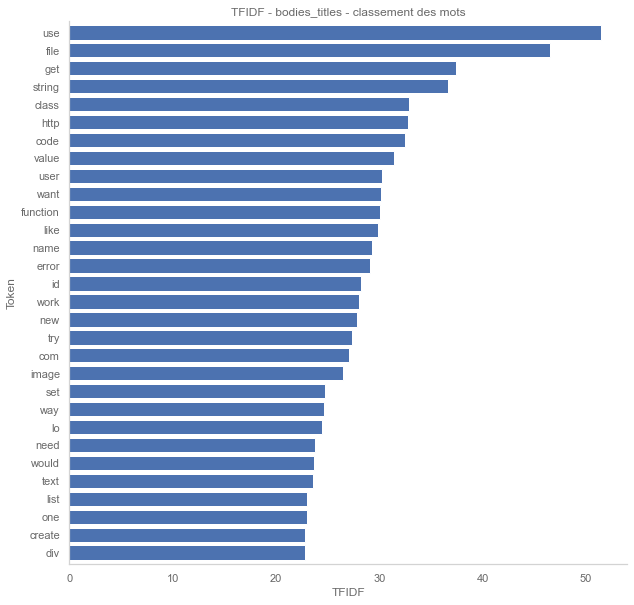

In [30]:
ax = sortedTFIDF_bodies_titles.head(N).plot(kind='barh', width=0.80)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TFIDF - bodies_titles - classement des mots')

Le calcul de TFIDF sur les corps et titres de message concaténés donne le même classement que pour le TFIDF sur les corps seuls.  
On preferera donc le TFIDF pondéré sur les titres et corps: TF-IDF_title * alpha + TF-IDF_body * (1-alpha).

In [31]:
X=dfTFIDF_bodies_titles.values

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


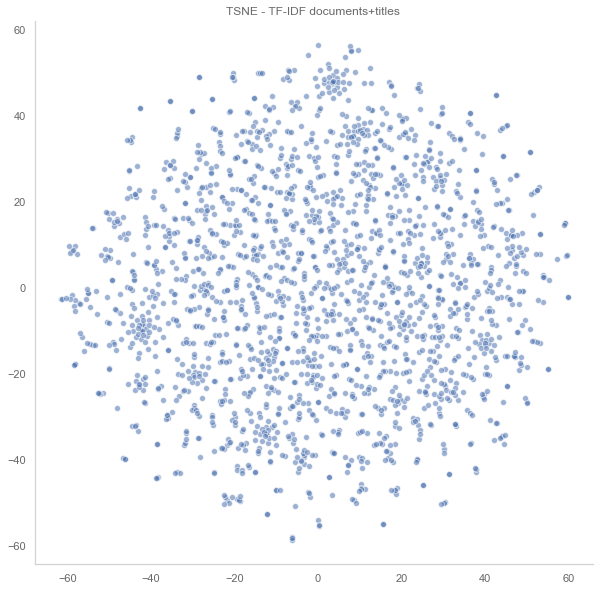

In [32]:
#%%time
tsne = TSNE(random_state=1, method='barnes_hut',n_iter=1000, n_components = 2)
tsne_results = tsne.fit_transform(X)

# graph TSNE
plt.figure(figsize = (10,10))


plt.scatter(tsne_results[:,0],tsne_results[:,1], edgecolor = "white", alpha=0.55)
plt.title('TSNE - TF-IDF documents+titles ')
plt.show()

des regroupements semblent apparaitre sur la visualisation TSNE, voyons le score de silhouette/nombre de clusters obtenu par clustering K-Means

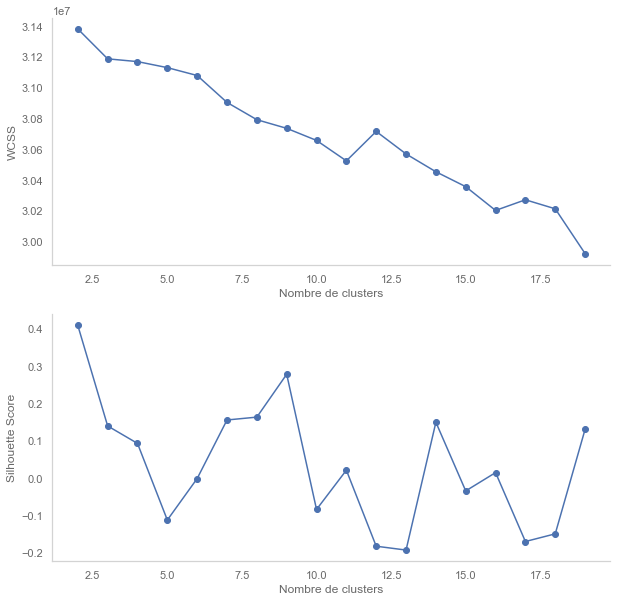

CPU times: user 9min 37s, sys: 33.1 s, total: 10min 10s
Wall time: 1min 5s


In [33]:
%%time
wcss=[] #  somme des carrés intra cluster (somme de la distance au carré entre chaque membre du cluster et son centroïde)
silhouettes=[]
centreReduit = preprocessing.StandardScaler().fit(X)
XCentreReduit = centreReduit.transform(X)

for n in range(2,20):
    cl = cluster.KMeans(n_clusters=n, init='k-means++')# pour avoir une initialisation aleatoire et unique
    y_pred=cl.fit_predict(XCentreReduit)# faire le clustering sur les données normalisée et calculer le coefficient de silhouette
    #labels=cl.labels_
    centroids=cl.cluster_centers_
    wcss.append(cl.inertia_)
    
    silhouette=metrics.silhouette_score(XCentreReduit,y_pred, metric='euclidean')
    silhouettes.append(silhouette)
    
plt.subplot(2, 1, 1);
plt.plot(range(2,20), wcss, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')

plt.subplot(2, 1, 2);
plt.plot(range(2,20), silhouettes, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.show()

Le score de silhouette <0.25 au dela de 2 clusters.  
Le clustering KMeans n'est pas concluant pour les titres et corps de messages concaténés.

## REDUCTION DIMENSIONNELLE - ACP

<AxesSubplot:>

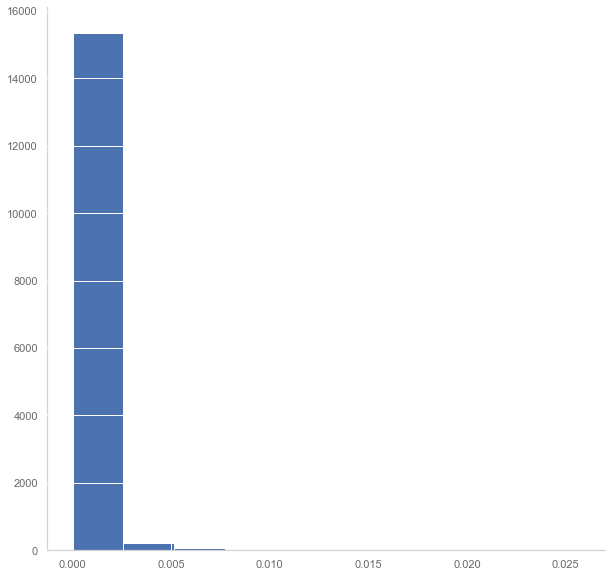

In [34]:
dfTFIDF_bodies_titles.mean(axis=0).hist()

La distribution des scores TFIDF est concentrée entre les valeurs 0 et 0.0025

In [35]:
# on ne garde que les token avec des TDFIDF significatif (>0.5)
df=dfTFIDFCommon[(dfTFIDFCommon.fillna(0))>0.01].fillna(0)
df.describe()

,graph,fps,assembly,nginx,compare,merchant,digit,normalization,differs,math,release,document,flush,exec,fluent,layoutview,open,toggle,border,xerces,resource,dxgdiplusclasses,composer,jna,django,...,number,record,highexpense,tournament,err,orange,safari,direction,taxonomy,rename,builder,tld,inclusion,picture,server,cipher,question,graphic,year,webview,uninstall,converter,rebuild,wizard,vim
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.001082,0.000320,0.001369,0.000330,0.000865,0.000184,0.000635,0.000181,0.000188,0.000550,0.000552,0.002048,0.000320,0.000457,0.000249,0.000235,0.002604,0.000560,0.000818,0.000267,0.001505,0.000235,0.000241,0.000218,0.002706,...,0.005509,0.002986,0.000266,0.000246,0.000472,0.000209,0.000289,0.000452,0.000262,0.000923,0.000514,0.000208,0.000245,0.000432,0.008754,0.000194,0.002323,0.000366,0.000792,0.000917,0.000316,0.000237,0.000243,0.000402,0.001232
std,0.019483,0.014298,0.020383,0.009711,0.017376,0.006981,0.015115,0.006478,0.008396,0.012069,0.012908,0.021359,0.011473,0.012144,0.010016,0.010495,0.026232,0.017297,0.018591,0.011335,0.020330,0.010524,0.009521,0.009743,0.032277,...,0.039132,0.031073,0.011897,0.010984,0.008998,0.007712,0.008668,0.010745,0.011055,0.021337,0.010369,0.009315,0.010391,0.010942,0.047033,0.008409,0.023884,0.010279,0.014323,0.020576,0.010647,0.008861,0.010110,0.011608,0.024603
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.462930,0.639428,0.424881,0.413631,0.494852,0.309040,0.518149,0.281173,0.375502,0.421872,0.565054,0.422120,0.510073,0.438463,0.444782,0.469345,0.460881,0.762132,0.522902,0.506227,0.398211,0.470639,0.423757,0.435738,0.606820,...,0.450466,0.62327

In [36]:
dataPCA=df
dataPCA.info(),dataPCA.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 2296 entries, graph to vim
dtypes: float64(2296)
memory usage: 35.0 MB


(None,
 Index(['graph', 'fps', 'assembly', 'nginx', 'compare', 'merchant', 'digit',
        'normalization', 'differs', 'math',
        ...
        'cipher', 'question', 'graphic', 'year', 'webview', 'uninstall',
        'converter', 'rebuild', 'wizard', 'vim'],
       dtype='object', length=2296))

In [37]:
X=dataPCA.values
variables=dataPCA.columns # Variables

In [38]:
centreReduit = preprocessing.StandardScaler().fit(X)
XCentreReduit = centreReduit.transform(X)
XCentreReduit.shape

(2000, 2296)

In [39]:
n_comp=1700 # n_comp <= nombre de variables
pca = decomposition.PCA(n_components=n_comp)
pca.fit(XCentreReduit)

PCA(n_components=1700)

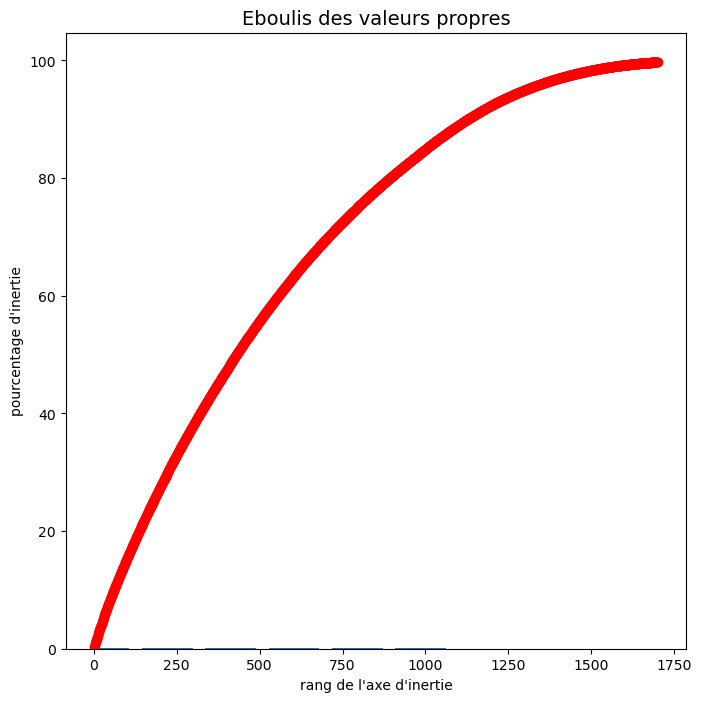

In [40]:
plt.style.use('default')
# taille du schema
plt.rcParams["figure.figsize"] = (8,8)

vectVarianceExpliquee = pca.explained_variance_ratio_*100 # renvoie les variences expliquées pour chacune des dimensions
plt.bar(np.arange(len(vectVarianceExpliquee))+1, vectVarianceExpliquee)
plt.plot(np.arange(len(vectVarianceExpliquee))+1, vectVarianceExpliquee.cumsum(),c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres",fontsize=14,fontweight='normal')
plt.show()

In [41]:
composantesPrincipales = pca.components_ # triés par variance expliquée

In [42]:
# Selection du plan Factoriel
#dimension 1
d1=0
#dimension 2
d2=1

<timed exec>:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


CPU times: user 53.1 ms, sys: 5.57 ms, total: 58.7 ms
Wall time: 55.9 ms


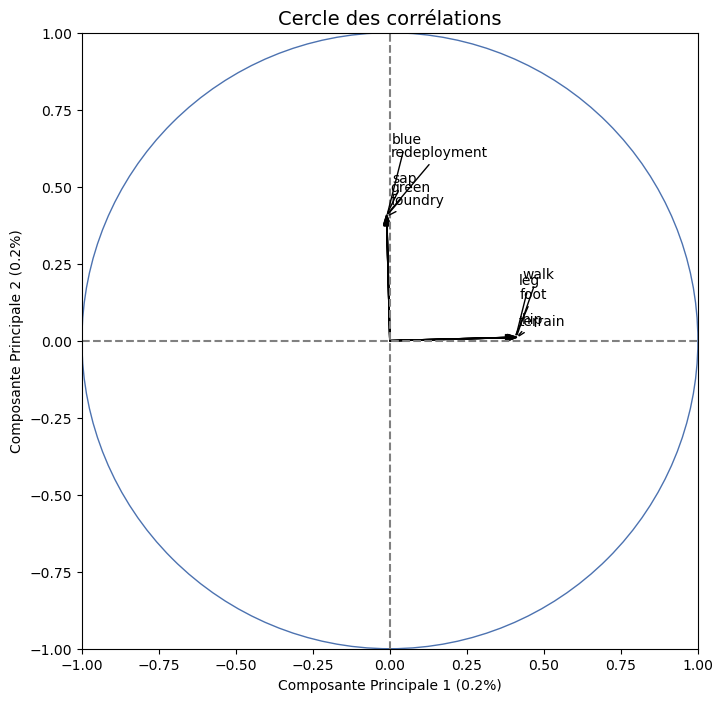

In [43]:
%%time
import random
plt.style.use('default')
# taille du schema
plt.rcParams["figure.figsize"] = (8,8)

fig, ax = plt.subplots()

# configuration de la bordure
plt.xlim(-1,1)
plt.ylim(-1,1)

# affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')

# libelles des axes
plt.xlabel('Composante Principale {} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
plt.ylabel('Composante Principale {} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))
plt.title('Cercle des corrélations',color="black",fontsize=14,fontweight='normal')
# afficher le cercle
cercle = plt.Circle((0,0),radius=1, color='b', fill=False)
ax.set_aspect(1)
ax.add_patch(cercle)

    
#placement des étiquettes des p variables + fleches (partant du centre vers les points projetés)
for i in range(len(variables)):
    p=np.array([composantesPrincipales[d1][i],composantesPrincipales[d2][i]])
    # on utilise la distance euclidienne pour n'afficher les labels que pour les individus loin du centre
    distance= np.linalg.norm(p-np.array([0,0]))        
    if distance>0.4:
        plt.annotate(variables[i],xy =(composantesPrincipales[d1][i],composantesPrincipales[d2][i]),xytext =(composantesPrincipales[d1][i]+(i*0.00001),composantesPrincipales[d2][i]+(i*0.00001*random.randint(2,18))),arrowprops=dict(arrowstyle="-",
                                connectionstyle="arc3")) 
        plt.arrow(0,0,composantesPrincipales[d1][i],composantesPrincipales[d2][i].astype(np.float),length_includes_head=True,head_width=0.02, head_length=0.03,color="black")

In [44]:
# Selection du plan Factoriel
#dimension 1
d1=1
#dimension 2
d2=2

<timed exec>:33: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


CPU times: user 45 ms, sys: 3 ms, total: 48 ms
Wall time: 45.8 ms


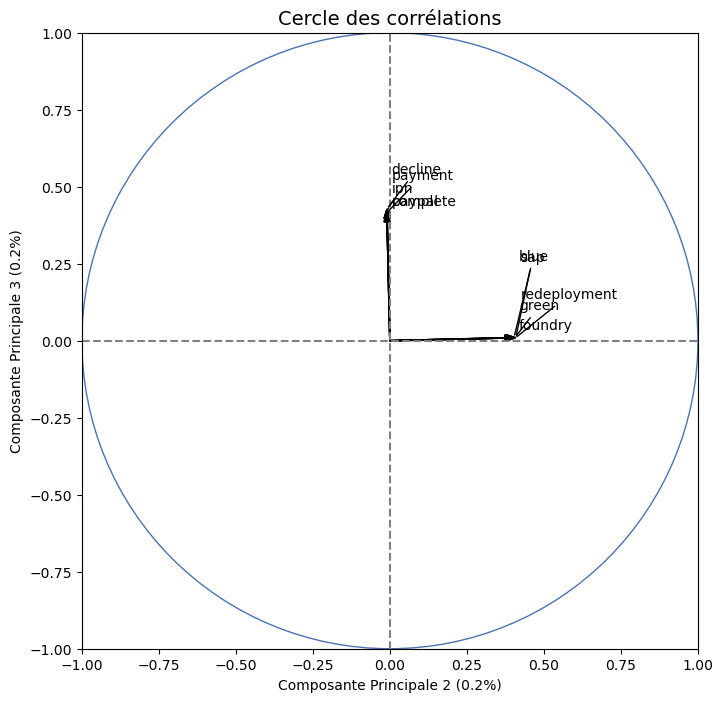

In [45]:
%%time
plt.style.use('default')
# taille du schema
plt.rcParams["figure.figsize"] = (8,8)

fig, ax = plt.subplots()

# configuration de la bordure
plt.xlim(-1,1)
plt.ylim(-1,1)

# affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')

# libelles des axes
plt.xlabel('Composante Principale {} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
plt.ylabel('Composante Principale {} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))
plt.title('Cercle des corrélations',color="black",fontsize=14,fontweight='normal')
# afficher le cercle
cercle = plt.Circle((0,0),radius=1, color='b', fill=False)
ax.set_aspect(1)
ax.add_patch(cercle)

    
#placement des étiquettes des p variables + fleches (partant du centre vers les points projetés)
for i in range(len(variables)):
    p=np.array([composantesPrincipales[d1][i],composantesPrincipales[d2][i]])
    # on utilise la distance euclidienne pour n'afficher les labels que pour les individus loin du centre
    distance= np.linalg.norm(p-np.array([0,0]))        
    if distance>0.38:
        plt.annotate(variables[i],xy =(composantesPrincipales[d1][i],composantesPrincipales[d2][i]),xytext =(composantesPrincipales[d1][i]+0.015,composantesPrincipales[d2][i]+(i*0.00001*random.randint(2,18))),arrowprops=dict(arrowstyle="-",
                                connectionstyle="arc3")) 
        plt.arrow(0,0,composantesPrincipales[d1][i],composantesPrincipales[d2][i].astype(np.float),length_includes_head=True,head_width=0.02, head_length=0.03,color="black")

In [46]:
composantesPrincipales[d1]

array([-0.00135098, -0.0004731 , -0.00271253, ...,  0.00071226,
       -0.0012097 , -0.0005625 ])

In [47]:
X.shape,composantesPrincipales[d1].shape,composantesPrincipales[d2].shape

((2000, 2296), (2296,), (2296,))

In [48]:
composantesPrincipales

array([[ 3.65064844e-05,  1.17288161e-04, -5.42982639e-04, ...,
        -7.70062668e-04, -1.09451821e-03, -1.02656487e-03],
       [-1.35097582e-03, -4.73101285e-04, -2.71252828e-03, ...,
         7.12263778e-04, -1.20970272e-03, -5.62498571e-04],
       [ 1.03698052e-03, -7.54521713e-04, -2.27016653e-03, ...,
         1.50713695e-03, -1.16935671e-03, -2.11539009e-03],
       ...,
       [ 2.81036307e-04, -2.19618625e-03,  4.57834104e-03, ...,
         1.87010736e-02,  3.03670486e-02, -3.04237251e-02],
       [-3.04496350e-02,  9.74731630e-04, -3.22524744e-02, ...,
        -1.35121992e-02, -1.26151287e-03,  8.20203086e-04],
       [-7.73255118e-03,  9.23844594e-03, -6.40226581e-04, ...,
         2.49354817e-02, -8.46797612e-03, -3.31543927e-02]])

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


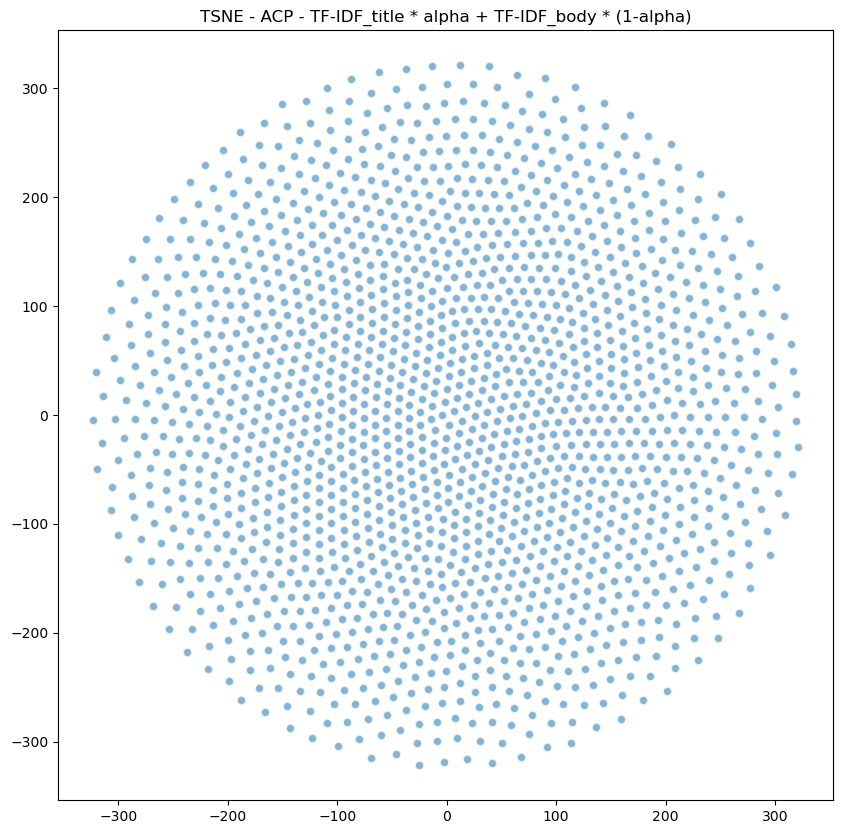

In [49]:
#%%time
tsne = TSNE(random_state=1, n_jobs=2,n_iter=1000, n_components = 2)
tsne_results = tsne.fit_transform(composantesPrincipales)
tsne_results.shape

# graph TSNE
plt.figure(figsize = (10,10))


plt.scatter(tsne_results[:,0],tsne_results[:,1], edgecolor = "white", alpha=0.55)
plt.title('TSNE - ACP - TF-IDF_title * alpha + TF-IDF_body * (1-alpha)')
plt.show()

## CLUSTERING

In [50]:
X=df.values

### KMeans

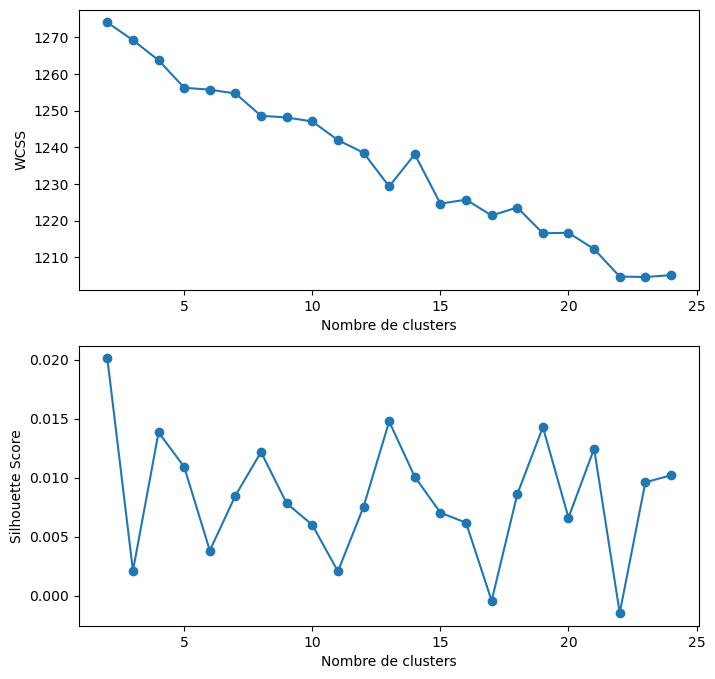

In [51]:
wcss=[] #  somme des carrés intra cluster (somme de la distance au carré entre chaque membre du cluster et son centroïde)
silhouettes=[]

for n in range(2,25):
    cl = cluster.KMeans(n_clusters=n, init='k-means++')# pour avoir une initialisation aleatoire et unique
    y_pred=cl.fit_predict(X)# faire le clustering sur les données normalisée et calculer le coefficient de silhouette
    #labels=cl.labels_
    centroids=cl.cluster_centers_
    wcss.append(cl.inertia_)
    
    silhouette=metrics.silhouette_score(X,y_pred, metric='euclidean')
    silhouettes.append(silhouette)
    
plt.subplot(2, 1, 1);
plt.plot(range(2,25), wcss, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')

plt.subplot(2, 1, 2);
plt.plot(range(2,25), silhouettes, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Bi-grams

In [52]:
# application de TF IDF de scikit learn sur le document
pd.options.display.max_colwidth=1000
pd.options.display.max_columns=80

vectorizer= TfidfVectorizer(ngram_range = (2,2))

In [53]:
response= vectorizer.fit_transform(bodies)
dfTFIDF_bodies=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_bodies=dfTFIDF_bodies.sum(axis=0).sort_values(ascending=False)

[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TFIDF Bigrams - bodies - classement des mots')]

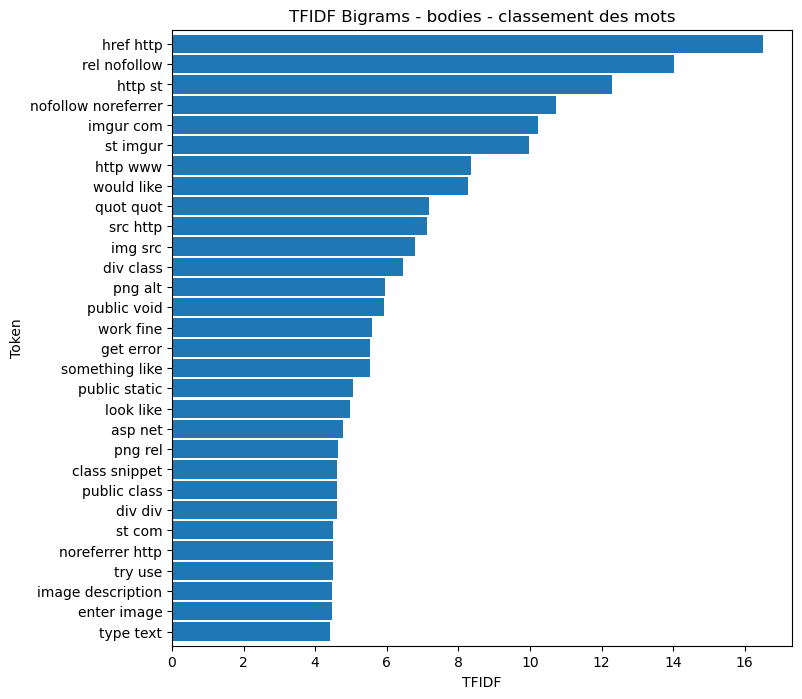

In [54]:
ax = sortedTFIDF_bodies.head(N).plot(kind='barh', width=0.90)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TFIDF Bigrams - bodies - classement des mots')

In [55]:
response= vectorizer.fit_transform(titles)
dfTFIDF_titles=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_titles=dfTFIDF_titles.sum(axis=0).sort_values(ascending=False)

[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TFIDF Bigrams - titles - classement des mots')]

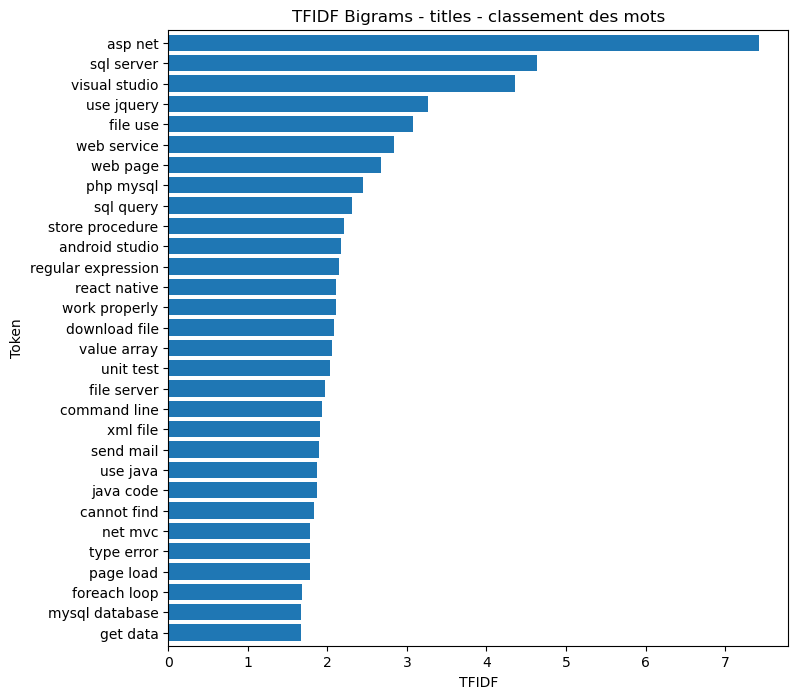

In [56]:
ax = sortedTFIDF_titles.head(N).plot(kind='barh', width=0.80)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TFIDF Bigrams - titles - classement des mots')

In [57]:
response= vectorizer.fit_transform(bodies_titles)
dfTFIDF_bodies_titles=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_bodies_titles=dfTFIDF_bodies_titles.sum(axis=0).sort_values(ascending=False)

[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TFIDF Bigrams - bodies+titles - classement des mots')]

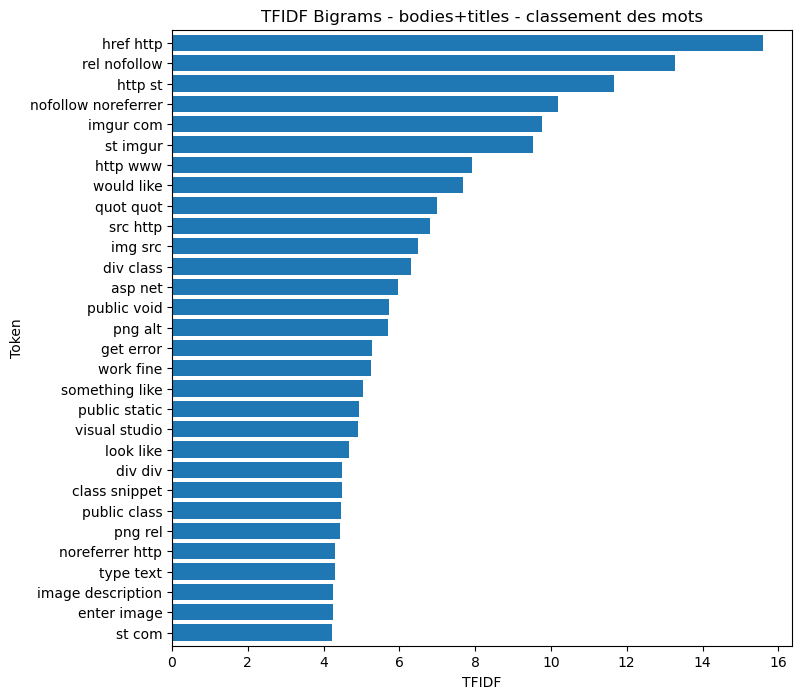

In [58]:
ax = sortedTFIDF_bodies_titles.head(N).plot(kind='barh', width=0.80)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TFIDF Bigrams - bodies+titles - classement des mots')

In [59]:
X=dfTFIDF_bodies_titles.values

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


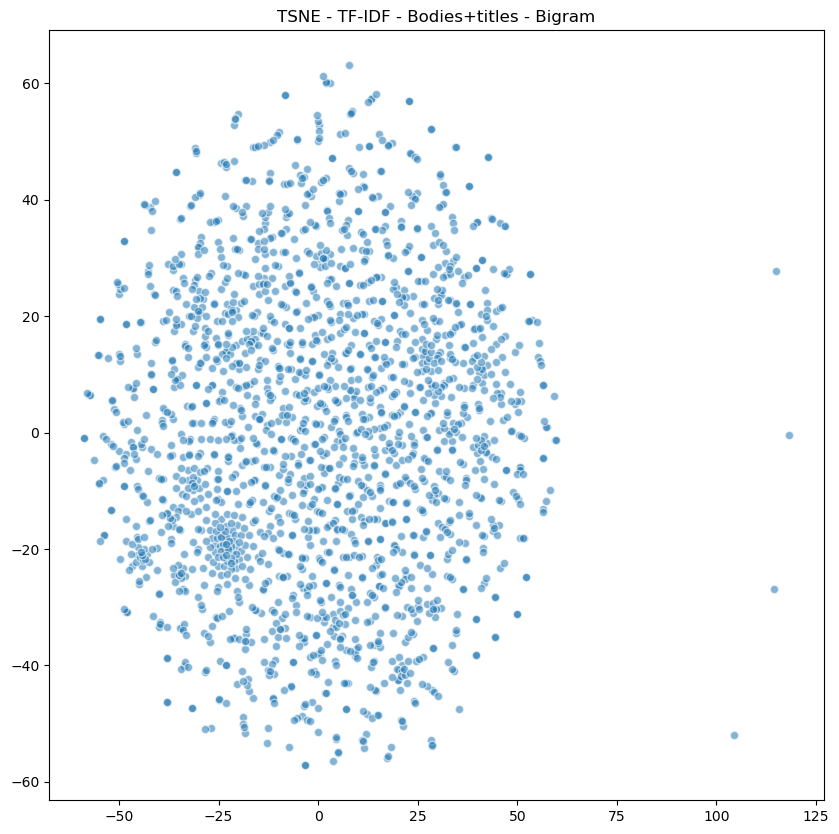

In [60]:
#%%time
tsne = TSNE(random_state=1, n_jobs=2,n_iter=1000, n_components = 2)
tsne_results = tsne.fit_transform(X)
tsne_results.shape

# graph TSNE
plt.figure(figsize = (10,10))


plt.scatter(tsne_results[:,0],tsne_results[:,1], edgecolor = "white", alpha=0.55)
plt.title('TSNE - TF-IDF - Bodies+titles - Bigram')
plt.show()

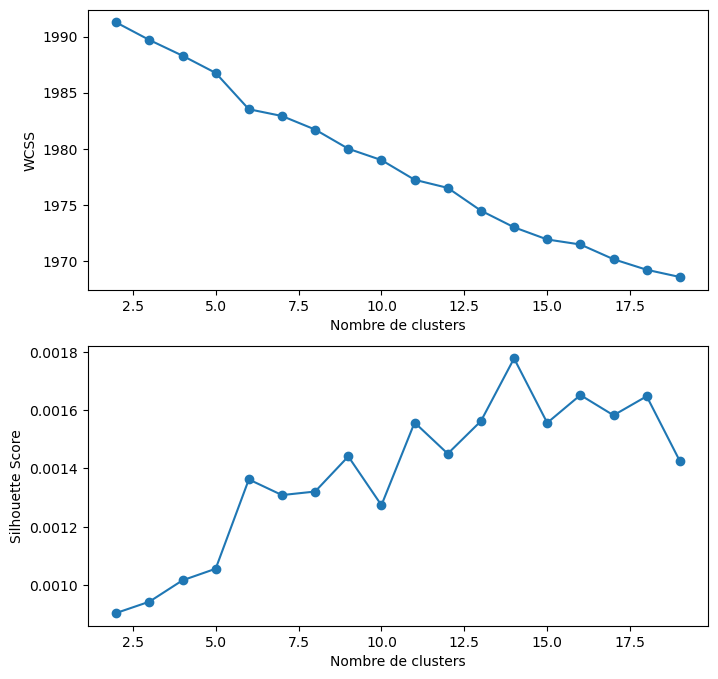

CPU times: user 3h 4min 50s, sys: 3min 14s, total: 3h 8min 5s
Wall time: 22min 45s


In [61]:
%%time
wcss=[] #  somme des carrés intra cluster (somme de la distance au carré entre chaque membre du cluster et son centroïde)
silhouettes=[]
#centreReduit = preprocessing.StandardScaler().fit(X)
#XCentreReduit = centreReduit.transform(X)

for n in range(2,20):
    cl = cluster.KMeans(n_clusters=n, init='k-means++')# pour avoir une initialisation aleatoire et unique
    y_pred=cl.fit_predict(X)# faire le clustering sur les données normalisée et calculer le coefficient de silhouette
    #labels=cl.labels_
    centroids=cl.cluster_centers_
    wcss.append(cl.inertia_)
    
    silhouette=metrics.silhouette_score(X,y_pred, metric='euclidean')
    silhouettes.append(silhouette)
    
plt.subplot(2, 1, 1);
plt.plot(range(2,20), wcss, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')

plt.subplot(2, 1, 2);
plt.plot(range(2,20), silhouettes, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [62]:
commonTokens=list(set(dfTFIDF_titles.columns) & set(dfTFIDF_bodies.columns))
dfTFIDFCommon=dfTFIDF_titles[commonTokens]*0.8+dfTFIDF_bodies[commonTokens]*0.2
sortedTFIDFCommon=dfTFIDFCommon.sum(axis=0).sort_values(ascending=False)

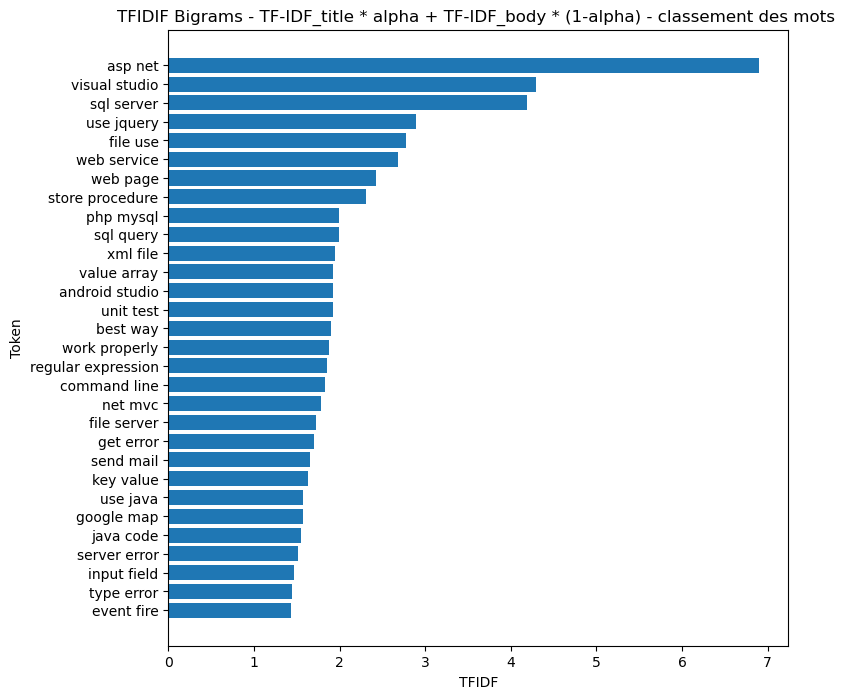

In [63]:
plt.figure(figsize=(8,8))

plt.barh(sortedTFIDFCommon.head(N).index,sortedTFIDFCommon.head(N).values)
plt.gca().invert_yaxis()

plt.xlabel("TFIDF")
plt.xticks(rotation='horizontal')

plt.ylabel("Token")
plt.title("TFIDIF Bigrams - TF-IDF_title * alpha + TF-IDF_body * (1-alpha) - classement des mots ")
plt.show()

In [64]:
X=dfTFIDFCommon.values

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


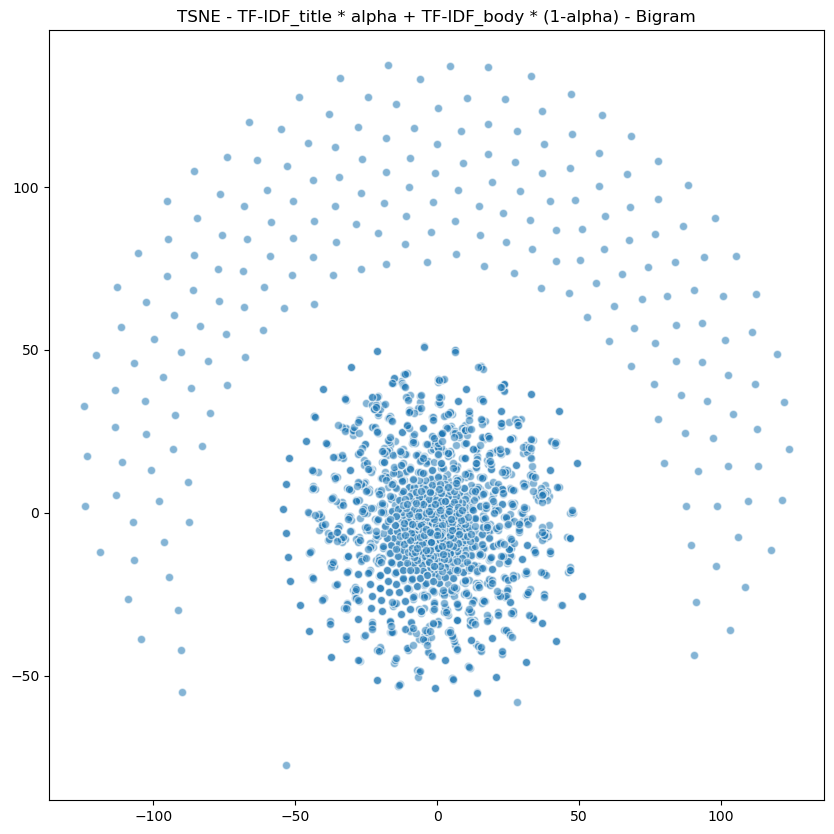

In [65]:
#%%time
tsne = TSNE(random_state=1, n_jobs=2,n_iter=1000, n_components = 2)
tsne_results = tsne.fit_transform(X)

plt.figure(figsize = (10,10))


plt.scatter(tsne_results[:,0],tsne_results[:,1], edgecolor = "white", alpha=0.55)
plt.title('TSNE - TF-IDF_title * alpha + TF-IDF_body * (1-alpha) - Bigram')
plt.show()

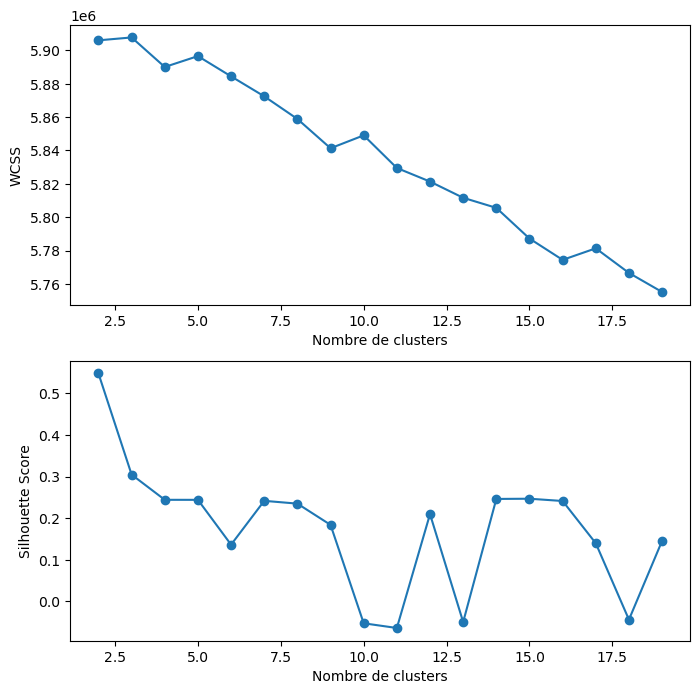

CPU times: user 2min 12s, sys: 2.43 s, total: 2min 14s
Wall time: 11.7 s


In [66]:
%%time
wcss=[] #  somme des carrés intra cluster (somme de la distance au carré entre chaque membre du cluster et son centroïde)
silhouettes=[]
centreReduit = preprocessing.StandardScaler().fit(X)
XCentreReduit = centreReduit.transform(X)

for n in range(2,20):
    cl = cluster.KMeans(n_clusters=n, init='k-means++')# pour avoir une initialisation aleatoire et unique
    y_pred=cl.fit_predict(XCentreReduit)# faire le clustering sur les données normalisée et calculer le coefficient de silhouette
    #labels=cl.labels_
    centroids=cl.cluster_centers_
    wcss.append(cl.inertia_)
    
    silhouette=metrics.silhouette_score(XCentreReduit,y_pred, metric='euclidean')
    silhouettes.append(silhouette)
    
plt.subplot(2, 1, 1);
plt.plot(range(2,20), wcss, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')

plt.subplot(2, 1, 2);
plt.plot(range(2,20), silhouettes, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [67]:
joblib.dump(dfTFIDFCommon,'dfTFIDFCommon.jbl.bz2')

['dfTFIDFCommon.jbl.bz2']

# Tri-grams

In [68]:
%%time
# application de TF IDF de scikit learn sur le document
pd.options.display.max_colwidth=1000
pd.options.display.max_columns=80

vectorizer= TfidfVectorizer(ngram_range = (3,3))



CPU times: user 6.08 ms, sys: 22.3 ms, total: 28.4 ms
Wall time: 33.4 ms


In [69]:
response= vectorizer.fit_transform(bodies)
dfTFIDF_bodies=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_bodies=dfTFIDF_bodies.sum(axis=0).sort_values(ascending=False)

[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TDFIDF Trigrams - bodies - classement des mots')]

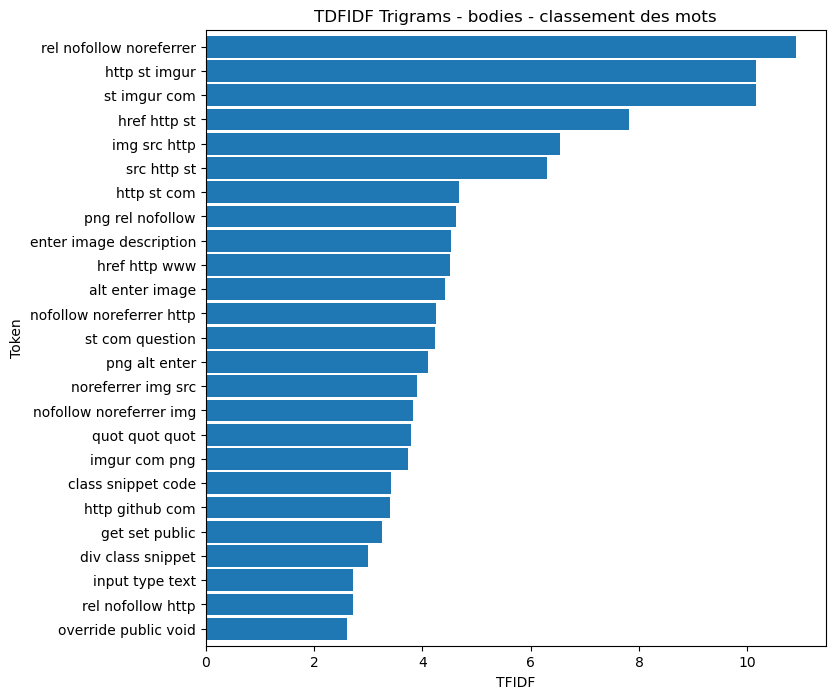

In [70]:
ax = sortedTFIDF_bodies.head(25).plot(kind='barh', width=0.90)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TDFIDF Trigrams - bodies - classement des mots')

In [71]:
response= vectorizer.fit_transform(titles)
dfTFIDF_titles=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_titles=dfTFIDF_titles.sum(axis=0).sort_values(ascending=False)

[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TDFIDF Trigrams - classement des mots')]

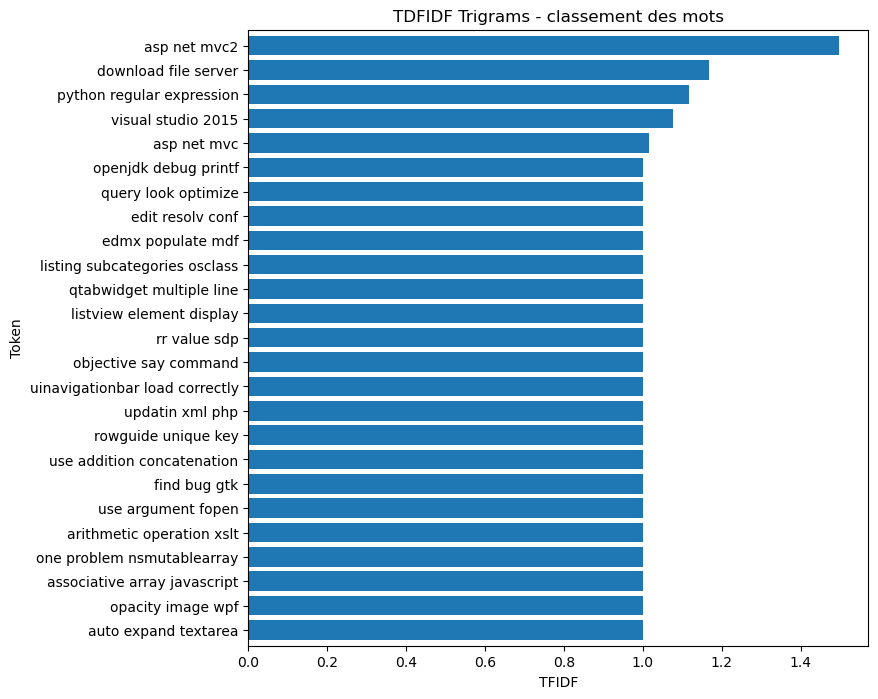

In [72]:
ax = sortedTFIDF_titles.head(25).plot(kind='barh', width=0.80)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TDFIDF Trigrams - classement des mots')

In [73]:
response= vectorizer.fit_transform(bodies_titles)
dfTFIDF_bodies_titles=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_bodies_titles=dfTFIDF_bodies_titles.sum(axis=0).sort_values(ascending=False)

[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TDFIDF Trigram - bodies+titles - classement des mots')]

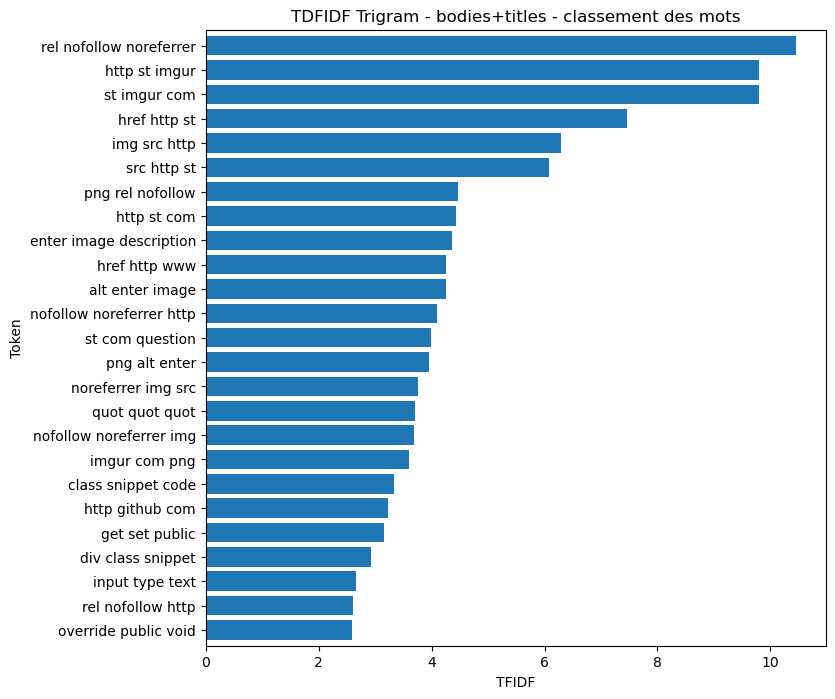

In [74]:
ax = sortedTFIDF_bodies_titles.head(25).plot(kind='barh', width=0.80)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TDFIDF Trigram - bodies+titles - classement des mots')

In [75]:
X=dfTFIDF_bodies_titles.values

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


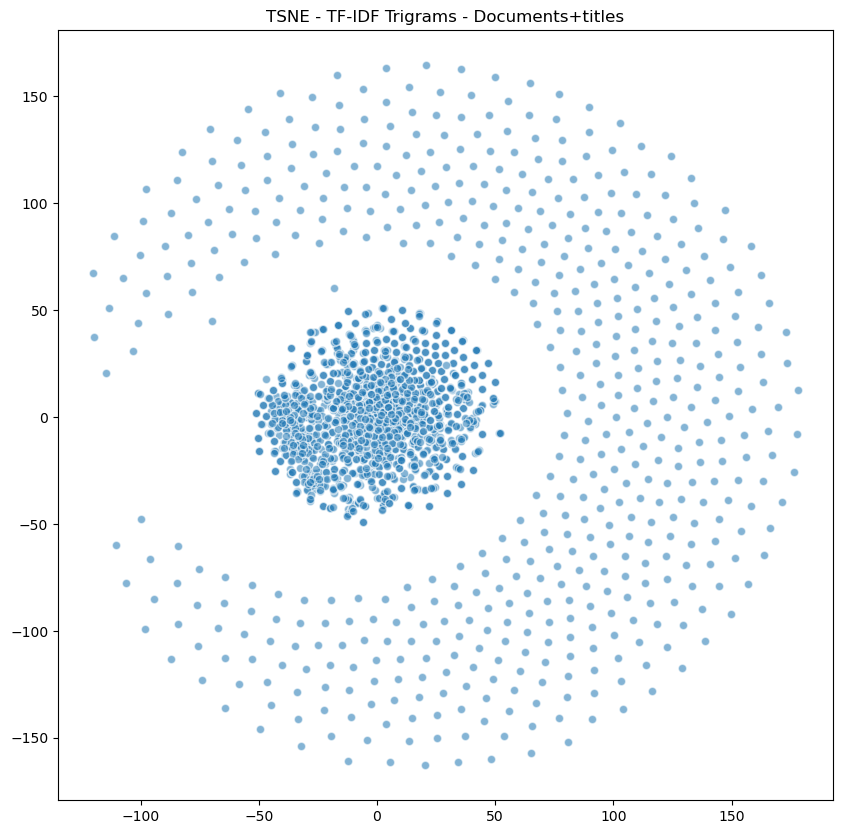

In [76]:
#%%time
tsne = TSNE(random_state=1, n_jobs=2,n_iter=1000, n_components = 2)
tsne_results = tsne.fit_transform(X)
tsne_results.shape

# graph TSNE
plt.figure(figsize = (10,10))


plt.scatter(tsne_results[:,0],tsne_results[:,1], edgecolor = "white", alpha=0.55)
plt.title('TSNE - TF-IDF Trigrams - Documents+titles')
plt.show()

In [77]:
X.shape

(2000, 162819)

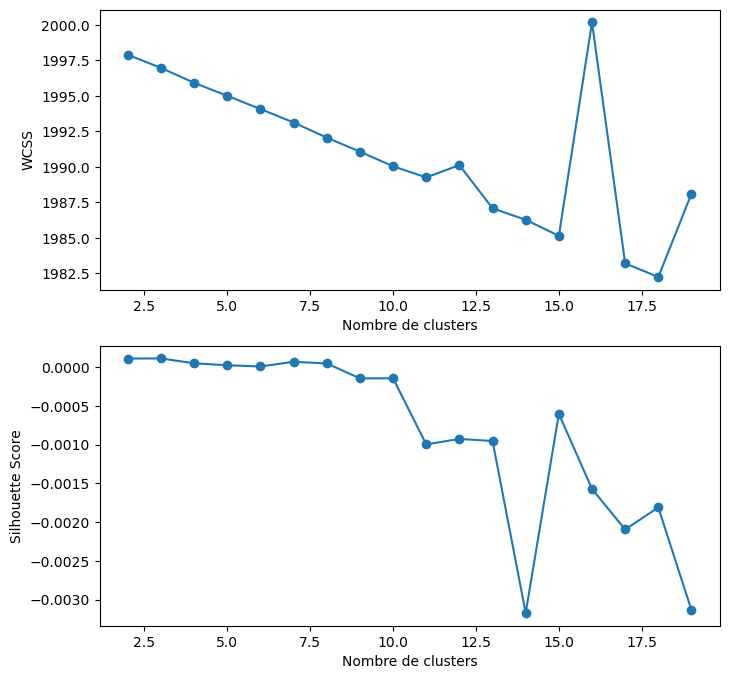

CPU times: user 30min 30s, sys: 52.5 s, total: 31min 23s
Wall time: 2min 54s


In [78]:
%%time
wcss=[] #  somme des carrés intra cluster (somme de la distance au carré entre chaque membre du cluster et son centroïde)
silhouettes=[]

for n in range(2,20):
    cl = cluster.MiniBatchKMeans(n_clusters=n, batch_size=10)# pour avoir une initialisation aleatoire et unique
    y_pred=cl.fit_predict(X)# faire le clustering sur les données normalisée et calculer le coefficient de silhouette
    #labels=cl.labels_
    centroids=cl.cluster_centers_
    wcss.append(cl.inertia_)
    
    silhouette=metrics.silhouette_score(X,y_pred, metric='euclidean')
    silhouettes.append(silhouette)
    
plt.subplot(2, 1, 1);
plt.plot(range(2,20), wcss, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')

plt.subplot(2, 1, 2);
plt.plot(range(2,20), silhouettes, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [79]:
commonTokens=list(set(dfTFIDF_titles.columns) & set(dfTFIDF_bodies.columns))
dfTFIDFCommon=dfTFIDF_titles[0:10000][commonTokens]*0.8+dfTFIDF_bodies[0:10000][commonTokens]*0.2
sortedTFIDFCommon=dfTFIDFCommon.sum(axis=0).sort_values(ascending=False)

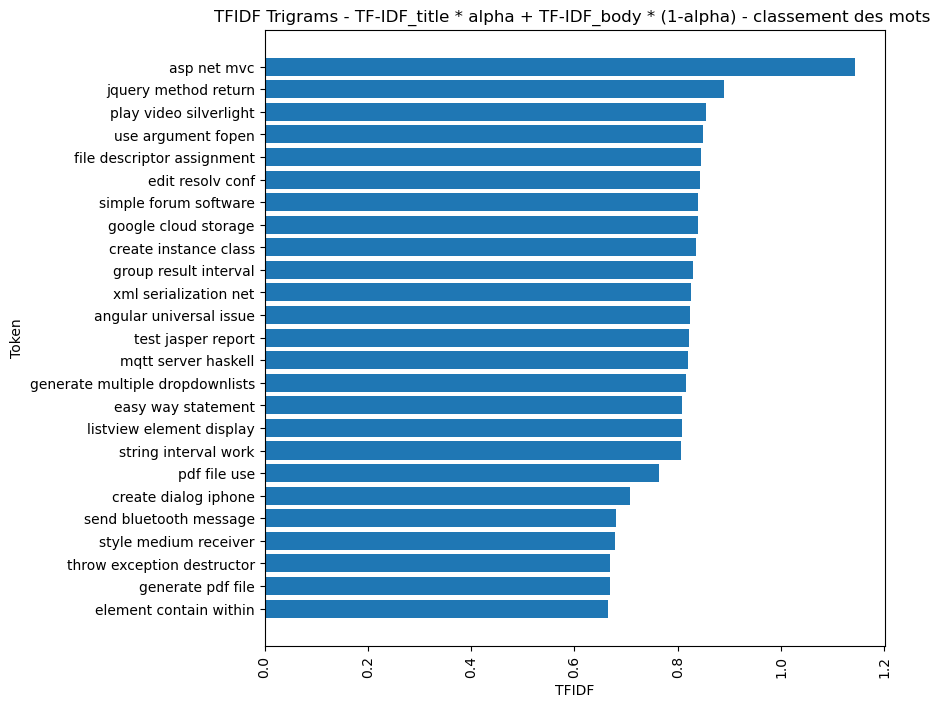

In [80]:
plt.figure(figsize=(8,8))

plt.barh(sortedTFIDFCommon.head(25).index,sortedTFIDFCommon.head(25).values)
plt.gca().invert_yaxis()

plt.xlabel("TFIDF")
plt.xticks(rotation='vertical')

plt.ylabel("Token")
plt.title("TFIDF Trigrams - TF-IDF_title * alpha + TF-IDF_body * (1-alpha) - classement des mots ")
plt.show()

In [81]:
X=dfTFIDFCommon

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


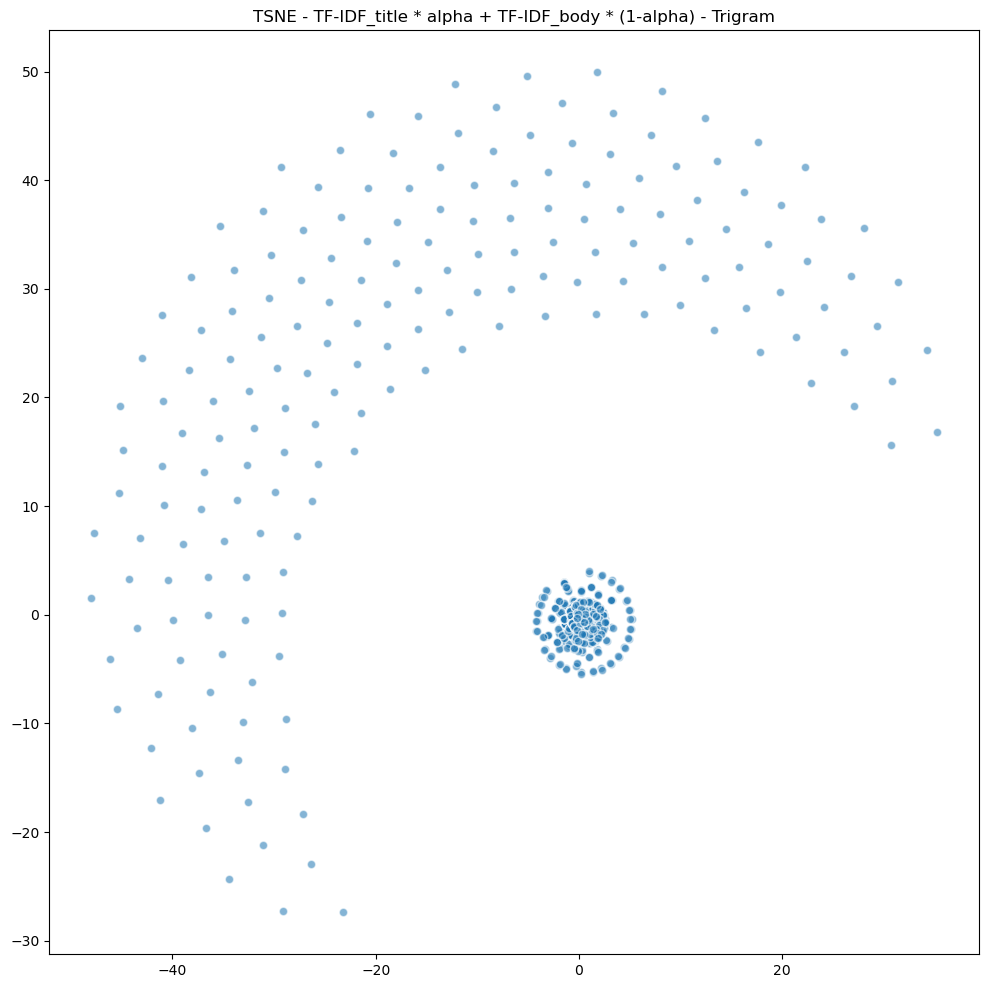

In [82]:
#%%time
tsne = TSNE(random_state=1, n_jobs=2,n_iter=1000, n_components = 2)
tsne_results = tsne.fit_transform(X)

# graph TSNE
plt.figure(figsize = (12,12))


plt.scatter(tsne_results[:,0],tsne_results[:,1], edgecolor = "white", alpha=0.55)
plt.title('TSNE - TF-IDF_title * alpha + TF-IDF_body * (1-alpha) - Trigram')
plt.show()

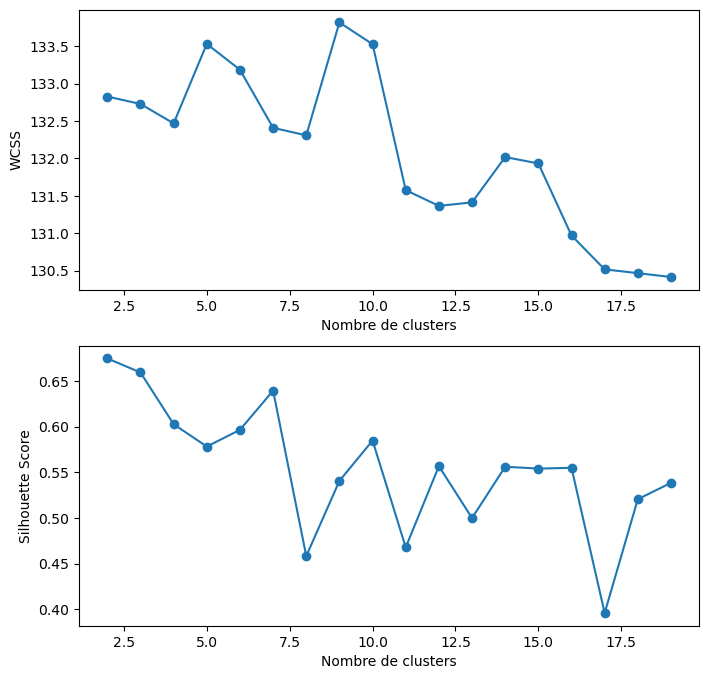

CPU times: user 24 s, sys: 734 ms, total: 24.8 s
Wall time: 2.17 s


In [83]:
%%time
wcss=[] #  somme des carrés intra cluster (somme de la distance au carré entre chaque membre du cluster et son centroïde)
silhouettes=[]

for n in range(2,20):
    cl = cluster.MiniBatchKMeans(n_clusters=n, batch_size=10)# pour avoir une initialisation aleatoire et unique
    y_pred=cl.fit_predict(X)# faire le clustering sur les données normalisée et calculer le coefficient de silhouette
    #labels=cl.labels_
    centroids=cl.cluster_centers_
    wcss.append(cl.inertia_)
    
    silhouette=metrics.silhouette_score(X,y_pred, metric='euclidean')
    silhouettes.append(silhouette)
    
plt.subplot(2, 1, 1);
plt.plot(range(2,20), wcss, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')

plt.subplot(2, 1, 2);
plt.plot(range(2,20), silhouettes, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Tags

In [84]:
tags=dfCleaned['Tags'].map(''.join)
tags

43576                                  c#  custom-controls  propertygrid  inplace-editing 
24783                                                      javascript  jquery  codemirror 
27941                                                      php  mysql  zend-search-lucene 
31045                                                                  javascript  jquery 
11525                                                 symfony  session  cookies  samesite 
35342                                                                 php  iis-7  caching 
5189                                                                angular  ng-bootstrap 
33560                                                                         c#  casting 
17916                                                                             jsf  el 
45286                                                               c#  screenshot  frame 
17193          azure-devops  azure-pipelines  azure-pipelines-tasks  azure-pipelines-yaml 

## Classement TF-IDF

In [85]:
vectorizer= TfidfVectorizer()

In [86]:
response= vectorizer.fit_transform(tags)
dfTFIDF_tags=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_tags=dfTFIDF_tags.sum(axis=0).sort_values(ascending=False)

[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TFIDF - tags - classement des mots')]

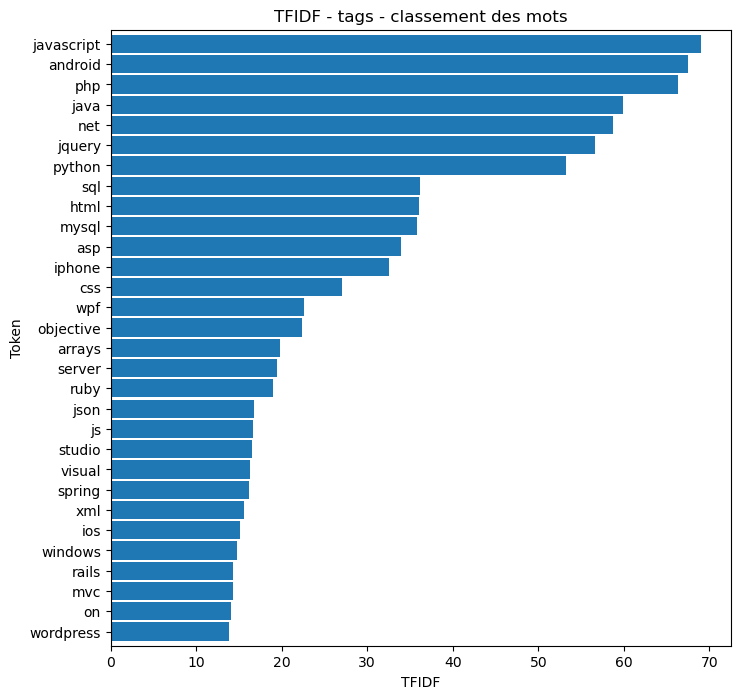

In [87]:
ax = sortedTFIDF_tags.head(N).plot(kind='barh', width=0.90)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TFIDF - tags - classement des mots')

## Labellisation

In [88]:
# correspondance Tag -> classe (1->20)
tagclass=sortedTFIDF_tags.head(N).to_dict()
for i, k in enumerate(tagclass):
    tagclass[k]=i+1
tagclass

{'javascript': 1,
 'android': 2,
 'php': 3,
 'java': 4,
 'net': 5,
 'jquery': 6,
 'python': 7,
 'sql': 8,
 'html': 9,
 'mysql': 10,
 'asp': 11,
 'iphone': 12,
 'css': 13,
 'wpf': 14,
 'objective': 15,
 'arrays': 16,
 'server': 17,
 'ruby': 18,
 'json': 19,
 'js': 20,
 'studio': 21,
 'visual': 22,
 'spring': 23,
 'xml': 24,
 'ios': 25,
 'windows': 26,
 'rails': 27,
 'mvc': 28,
 'on': 29,
 'wordpress': 30}

In [89]:
joblib.dump(tagclass,'tagclass.jbl.bz2')

['tagclass.jbl.bz2']

Voici les N tags les plus utilisés.
Que nous utiliserons comme target.

In [90]:
# filtrage des colonnes du dataset contenant les tags
cols=[]
for i,k in enumerate(tagclass):
    regexstring='.*'+k+'.*' # on recherche les chaines contenant le tag k
    cols = cols+[c for c in dfTFIDFCommon.columns if re.match(regexstring,c.lower())] # si le tag est trouvé on ajoute la colonne à notre liste de colonnes à conserver
cols=list(set(cols))

In [91]:
dfTFIDFCommonTarget=dfTFIDFCommon[cols]
dfTFIDFCommonTarget.sample(8)

,use undefined constant,drivelistbox dot net,edit resolv conf,one dimensional array,manipulate parse json,convert jar file,sql server use,long line code,java lang runtimeexception,primary nest exception,path live server,array one string,reference one file,classroom share button,nest exception org,get svn revision,control tree structure,internet connection error,use ocx control,language vbscript jscript,complex union structure,exception org hibernate,launch android studio,array javascript java,depends version net,rail tzinfo timezone,sql statement could,use jquery cycle,web service asp,test jasper report,bindparam non object,new java program,array one element,attribute xml clob,drop list json,printing html form,total amount session,server set nocount,wordpress well zend,pythonic way check,...,many many relationship,attributeerror function object,android studio create,org hibernate exception,gzip javascript file,connector task assign,another html twig,instance ironpython class,single key json,one file exist,xml file use,possible orientation cube,function one url,value nokogiri xml,javascript array array,error execution fail,asp net mvc,point live server,upon press button,type sql statement,convert one dimensional,top horizontal axis,query take long,non cluster index,build non binary,input xml file,type authorization net,inside another html,extension method use,mask url php,service asp net,url use jquery,change config file,control size container,control drivelistbox dot,sql server set,job asp net,one many relationship,detect server run,delayed job asp
467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1644,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1910,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
513,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1539,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [92]:
joblib.dump(dfTFIDFCommonTarget,'dfTFIDFCommonTarget.jbl.bz2')

['dfTFIDFCommonTarget.jbl.bz2']

In [93]:
elapsed=time.time() - start
elapsed

1756.915058851242